### Multiple Classification(다중 분류 모델)
* 회로 기판이 불량이라면 어떤 유형의 불량인지를 출력하고자 함

#### 1. 환경설정

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

#### 2. 데이터 불러오기

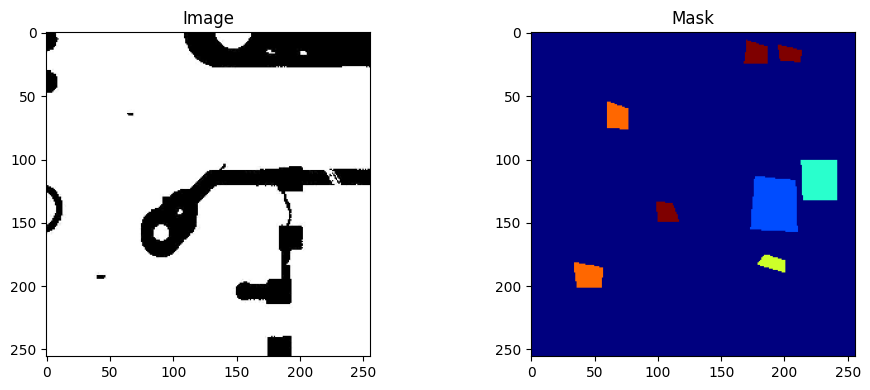

In [ ]:
#60개의 mask 이미지를 적용, Defect 이미지도 동일한 파일 60장을 따로 폴더를 만들어 저장, 불러옴
Defect_image_dir = "./DeepPCB_split/labeling/test_Defect"
mask_dir = "./DeepPCB_split/labeling/mask"
img_size = (256, 256)

def load_data(image_dir, mask_dir, img_size=(256, 256)):
    image_files = sorted(os.listdir(image_dir))
    images, masks = [], []

    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]    

    for file_name in image_files:
        # 1. 이미지 로드
        img = load_img(os.path.join(image_dir, file_name), target_size=img_size)
        img = img_to_array(img) / 255.0

        # 2. 마스크 파일명은 .png로 변경
        mask_file = file_name.replace('.jpg', '.png')  # 또는 .jpeg도 있으면 대응
        mask_path = os.path.join(mask_dir, mask_file)

        # 3. 마스크 로드
        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
        mask = img_to_array(mask).squeeze().astype('int32')  # [H, W]

        # 4. 저장
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)
#데이터 불러오기
images, masks = load_data(Defect_image_dir, mask_dir)
num_classes = np.max(masks) + 1
masks_cat = tf.keras.utils.to_categorical(masks, num_classes = num_classes)

def visualize_sample(images, masks, index=0):
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask.argmax(axis=-1), cmap='jet')

    plt.tight_layout()
    plt.show()

# 실행
visualize_sample(images, masks_cat, index=0)

In [8]:
# 데이터 분할(학습 / 검증 데이터로 나누기)
from sklearn.model_selection import train_test_split
print("전체 데이터 수:", images.shape[0])

# train:validation = 80:20으로 분할
X_train, X_val, y_train, y_val = train_test_split(
    images,           # 입력 이미지들 (N, 256, 256, 3)
    masks_cat,        # 원-핫 마스크들 (N, 256, 256, num_classes)
    test_size=0.2,    # 20%는 검증용으로 사용
    random_state=42,  # 결과 재현을 위한 시드값
    shuffle=True      # 데이터 섞기 (불량 클래스 고르게 분포)
)

# 결과 확인
print(f"✅ 학습 이미지 수: {X_train.shape[0]}")
print(f"✅ 검증 이미지 수: {X_val.shape[0]}")

전체 데이터 수: 61
✅ 학습 이미지 수: 48
✅ 검증 이미지 수: 13


In [10]:
def build_unet(input_shape=(256, 256, 3), num_classes=6):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D()(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = models.Model(inputs, outputs)
    return model

# 모델 생성 및 컴파일
unet_model = build_unet(input_shape=(256, 256, 3), num_classes=num_classes)
unet_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# 구조 확인
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [17]:
# 모델 학습
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=10
)

Epoch 1/10
6/6 [==============================] - 1s 208ms/step - loss: 0.1962 - accuracy: 0.9586 - val_loss: 0.2431 - val_accuracy: 0.9542
Epoch 2/10
6/6 [==============================] - 1s 202ms/step - loss: 0.2058 - accuracy: 0.9586 - val_loss: 0.2172 - val_accuracy: 0.9542
Epoch 3/10
6/6 [==============================] - 1s 201ms/step - loss: 0.1970 - accuracy: 0.9586 - val_loss: 0.2271 - val_accuracy: 0.9542
Epoch 4/10
6/6 [==============================] - 1s 204ms/step - loss: 0.1973 - accuracy: 0.9586 - val_loss: 0.2133 - val_accuracy: 0.9542
Epoch 5/10
6/6 [==============================] - 1s 202ms/step - loss: 0.1901 - accuracy: 0.9586 - val_loss: 0.2198 - val_accuracy: 0.9542
Epoch 6/10
6/6 [==============================] - 1s 203ms/step - loss: 0.1861 - accuracy: 0.9586 - val_loss: 0.2031 - val_accuracy: 0.9542
Epoch 7/10
6/6 [==============================] - 1s 201ms/step - loss: 0.1810 - accuracy: 0.9586 - val_loss: 0.1987 - val_accuracy: 0.9542
Epoch 8/10
6/6 [====

1/1 [==============================] - 0s 15ms/step


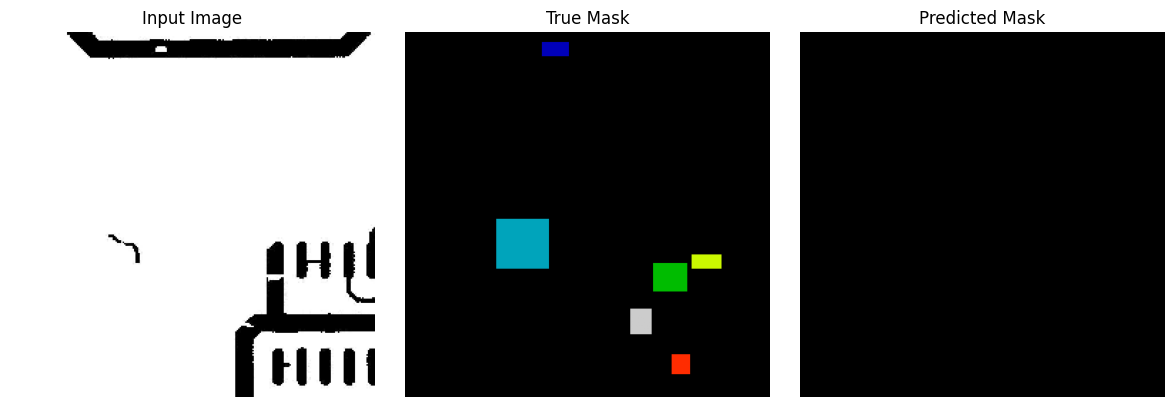

1/1 [==============================] - 0s 16ms/step


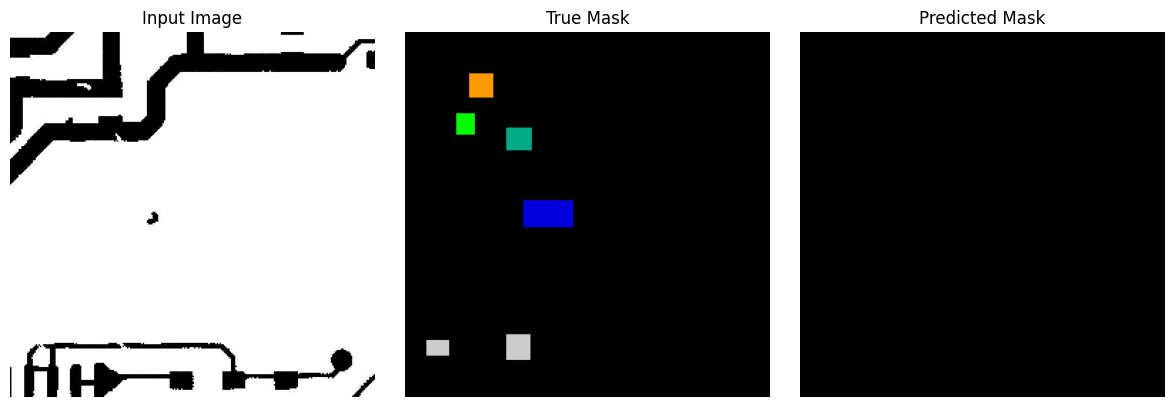

1/1 [==============================] - 0s 15ms/step


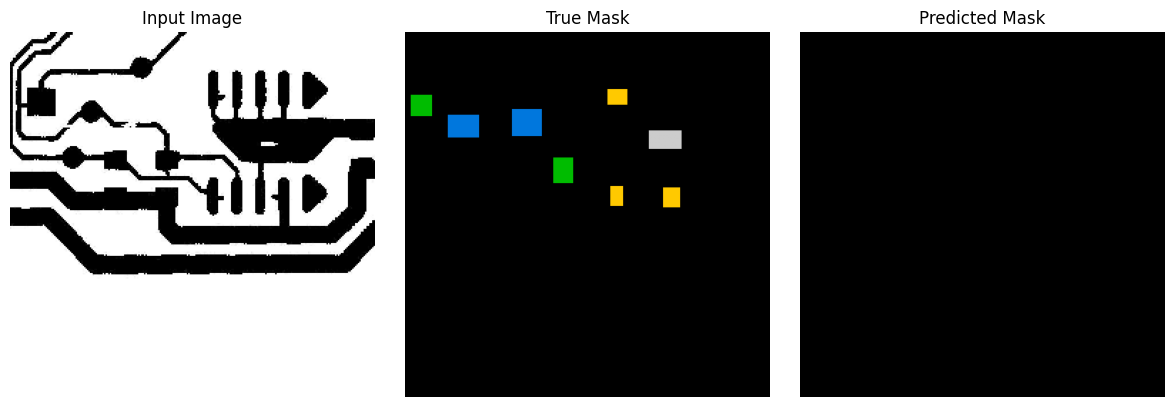

1/1 [==============================] - 0s 15ms/step


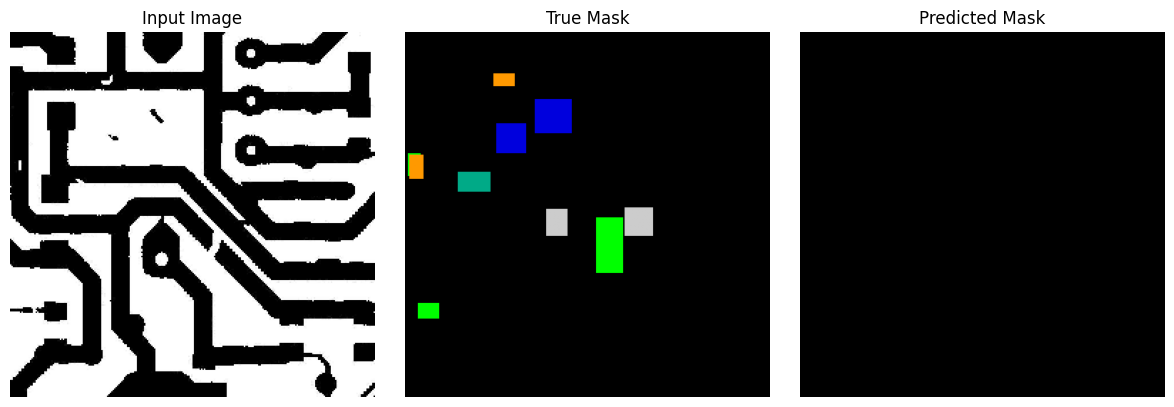

1/1 [==============================] - 0s 15ms/step


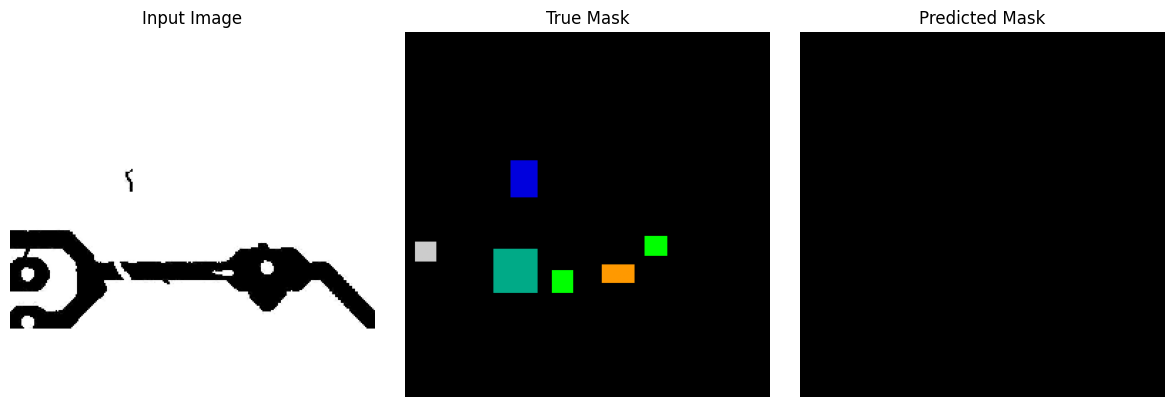

In [18]:

# 하나 또는 일부 샘플에 대해 예측
def visualize_prediction(model, images, masks, num_samples=30):
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i in indices:
        image = np.expand_dims(images[i], axis=0)  # [1, H, W, 3]
        pred = model.predict(image)
        pred_mask = np.argmax(pred.squeeze(), axis=-1)  # [H, W]
        true_mask = np.argmax(masks[i], axis=-1)        # [H, W]

        # 시각화
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='nipy_spectral')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='nipy_spectral')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

visualize_prediction(unet_model, X_val, y_val, num_samples=5)  